# Problem Set #8
MACS 30150, Dr. Evans  
Minghao Yang

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
import graphviz
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

## 1. Decision Trees (5 points)
### (a)

In [2]:
# Load the data as a dataframe
df1 = pd.read_csv('biden.csv')
df1.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


In [3]:
# Check if there are missing values
df1.isnull().sum()

biden     0
female    0
age       0
educ      0
dem       0
rep       0
dtype: int64

In [4]:
# Sample splitting
X_1a = df1[['female', 'age', 'educ', 'dem', 'rep']]
y_1a = df1['biden']
X_train_1a, X_test_1a, y_train_1a, y_test_1a = train_test_split(X_1a, y_1a, test_size=0.3, random_state=25)

In [5]:
# Tree-based methods
biden_tree_1a = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_tree_1a.fit(X_train_1a, y_train_1a)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

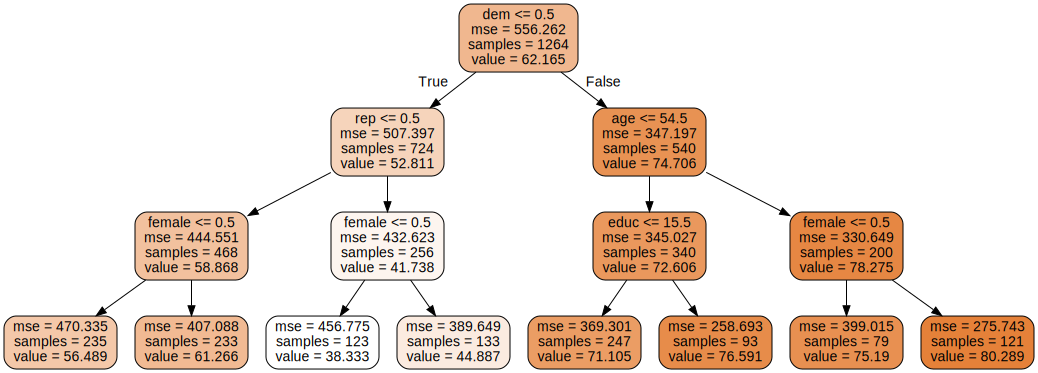

In [6]:
# Draw the tree
biden_tree_viz_1a = export_graphviz(
    biden_tree_1a,
    out_file=None,
    feature_names=['female', 'age', 'educ', 'dem', 'rep'],
    class_names=['biden'],
    rounded=True,
    filled=True,
)

graph_1a = graphviz.Source(biden_tree_viz_1a)
graph_1a

The above tree shows the cutoffs that minimize the mean squared errors in each feature space when we predict `biden` with the training set. The first node splits the population based on whether they are Democratic or not, with left branch representing non-Democratics and right branch representing Democratics. The non-Democratic population is then splited based on whether they are Repulican or not, with left branch representing non-Republicans and right branch representing Republicans. The non-Republican population is then splited by gender, with left branch representing males and right branch representing females. The Republican population is also splited by gender, with left branch representing males and right branch representing females. The Democratic population is further splited by their age, with left branch representing individuals who are less than 55 years old (referred to as the younger population) and right branch representing representing individuals who are at least 55 years old (referred to as the older population). The younger population is then splited by their education level, with left branch representing individuals who receive less than 16 years of schooling and right branch representing individuals who receive at least 16 years of schooling. The older population is then splited by gender, with left branch representing males and right branch representing females. After the above splitting, we end up with eight different feature spaces. To predict `biden` of a specific individual, we need to first determine which space he or she is in and then use the average `biden` of that space as the predict value.  

In [7]:
# Calculate the test MSE
y_pred_1a = biden_tree_1a.predict(X_test_1a)
MSE_1a = mean_squared_error(y_test_1a, y_pred_1a)
print('The test MSE is', MSE_1a)

The test MSE is 396.1937146321307


### (b)

In [8]:
# Specify parameter distributions as suggested
param_dist_1b = {'max_depth': [3, 10],
                 'min_samples_split': sp_randint(2, 20),
                 'min_samples_leaf': sp_randint(2, 20)}

biden_tree_1b = DecisionTreeRegressor()

# Run randomized hyperparameter search
random_search_1b = RandomizedSearchCV(biden_tree_1b, param_distributions=param_dist_1b,
                                      n_iter=100, n_jobs=-1, cv=5, random_state=25,
                                      scoring='neg_mean_squared_error')

random_search_1b.fit(X_1a, y_1a)
print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_1b.best_params_)
print('The MSE of the optimal results is', -random_search_1b.best_score_)

The optimal tuning parameter values from randomized hyperparameter search are
 {'max_depth': 3, 'min_samples_leaf': 17, 'min_samples_split': 14}
The MSE of the optimal results is 401.713307249986


### (c)

In [9]:
# Specify parameter distributions as suggested
param_dist_1c = {'n_estimators': [10, 200],
                 'max_depth': [3, 10],
                 'min_samples_split': sp_randint(2, 20),
                 'min_samples_leaf': sp_randint(2, 20),
                 'max_features': sp_randint(1, 5)}

biden_tree_1c = RandomForestRegressor(bootstrap=True, oob_score=True, random_state=25)

# Run randomized hyperparameter search
random_search_1c = RandomizedSearchCV(biden_tree_1c, param_distributions=param_dist_1c,
                                      n_iter=100, n_jobs=-1, cv=5, random_state=25,
                                      scoring='neg_mean_squared_error')

random_search_1c.fit(X_1a, y_1a)
print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_1c.best_params_)
print('The MSE of the optimal results is', -random_search_1c.best_score_)

The optimal tuning parameter values from randomized hyperparameter search are
 {'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 17, 'min_samples_split': 13, 'n_estimators': 10}
The MSE of the optimal results is 397.09673478564173


C:\Users\Thinkpad\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


## 2. Classifier "horse" race (5 points)

### (a)

In [10]:
# Load the data as a dataframe and deal with missing data
df2 = pd.read_csv('Auto.csv', na_values='?')
df2.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [11]:
# Check the missing values
df2.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      5
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

In [12]:
# Given that there are only five missing values in horsepower, 
# we could drop these observations without losing much information
df2.dropna(inplace=True)

In [13]:
# Return the median of mpg
print(df2['mpg'].median())

22.75


In [14]:
# Generate the binary variable for mpg
df2['mpg_high'] = (df2['mpg'] >= df2['mpg'].median()).astype('int32')

# Generate the binary variables for origin
df2['origin1'] = (df2['origin'] == 1).astype('int32')
df2['origin2'] = (df2['origin'] == 2).astype('int32')

# Generate dependent and independent variables
X_2a = df2[['cylinders', 'displacement', 'horsepower', 'weight',
            'acceleration', 'year', 'origin1', 'origin2']]
y_2a = df2['mpg_high']
Xvars_2a = X_2a.values
yvars_2a = y_2a.values

# Notice that I do not need to create a constant in X_2a because the LogisticRegression from 
# sklearn.linear_model automatically adds a constant when estimating the model and we can 
# use .intercept_ to see the coefficient of the constant.

In [15]:
# Set basic parameters
kf_log_2a = KFold(n_splits=4, random_state=25, shuffle=True)
kf_log_2a.get_n_splits(Xvars_2a)
MSE_vec_2a = np.zeros(4)
ER_high_vec_2a = np.zeros(4)
ER_low_vec_2a = np.zeros(4)
k_ind = int(0)

# Calculate the MSE by loop
for train_index, test_index in kf_log_2a.split(Xvars_2a):
    # print("TRAIN:", train_index, "TEST:", test_index)
    # print('k index=', k_ind)
    X_train_2a, X_test_2a = Xvars_2a[train_index], Xvars_2a[test_index]
    y_train_2a, y_test_2a = yvars_2a[train_index], yvars_2a[test_index]
    clf_2a = LogisticRegression(solver='lbfgs', max_iter=1000)
    clf_2a.fit(X_train_2a, y_train_2a)
    y_pred_2a = clf_2a.predict(X_test_2a)
    MSE_vec_2a[k_ind] = (1 - (y_test_2a == y_pred_2a)).mean()
    ER_high_vec_2a[k_ind] = ((y_test_2a == 1) & (y_pred_2a != 1)).sum() / (y_test_2a == 1).sum()
    ER_low_vec_2a[k_ind] = ((y_test_2a == 0) & (y_pred_2a != 0)).sum() / (y_test_2a == 0).sum()
    # print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf_2a = MSE_vec_2a.mean()
ER_high_kf_2a = ER_high_vec_2a.mean()
ER_low_kf_2a = ER_low_vec_2a.mean()
print('The K-fold estimate for the test MSE is', MSE_kf_2a)
print('The error rate for mpg_high == 1 of the test set is', ER_high_kf_2a)
print('The error rate for mpg_high == 0 of the test set is', ER_low_kf_2a)

The K-fold estimate for the test MSE is 0.09693877551020408
The error rate for mpg_high == 1 of the test set is 0.07486931885129128
The error rate for mpg_high == 0 of the test set is 0.11946101633984131


### (b)

In [16]:
# Specify parameter distributions as suggested
param_dist_2b = {'n_estimators': [10, 200],
                 'max_depth': [3, 8],
                 'min_samples_split': sp_randint(2, 20),
                 'min_samples_leaf': sp_randint(2, 20),
                 'max_features': sp_randint(1, 8)}

mpg_forest_2b = RandomForestClassifier(bootstrap=True, oob_score=True, random_state=25)

# Run randomized hyperparameter search
random_search_2b = RandomizedSearchCV(mpg_forest_2b, param_distributions=param_dist_2b,
                                      n_iter=100, n_jobs=-1, cv=4, random_state=25,
                                      scoring='neg_mean_squared_error')

random_search_2b.fit(X_2a, y_2a)
print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_2b.best_params_)
print('The MSE of the optimal results is', -random_search_2b.best_score_)

The optimal tuning parameter values from randomized hyperparameter search are
 {'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 10}
The MSE of the optimal results is 0.08928571428571429


C:\Users\Thinkpad\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Thinkpad\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


### (c)

In [17]:
# Specify parameter distributions as suggested
param_dist_2c = {'C': sp_uniform(loc=0.2, scale=4.0),
                 'gamma': ['scale', 'auto'],
                 'shrinking': [True, False]}

mpg_svc_2c = SVC(kernel='rbf')

# Run randomized hyperparameter search
random_search_2c = RandomizedSearchCV(mpg_svc_2c, param_distributions=param_dist_2c,
                                      n_iter=100, n_jobs=-1, cv=4, random_state=25,
                                      scoring='neg_mean_squared_error')

random_search_2c.fit(X_2a, y_2a)
print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_2c.best_params_)
print('The MSE of the optimal results is', -random_search_2c.best_score_)

The optimal tuning parameter values from randomized hyperparameter search are
 {'C': 1.8094629152568114, 'gamma': 'scale', 'shrinking': False}
The MSE of the optimal results is 0.11989795918367346


### (d)

The best predictor of `mpg_high` is the random forest classifier since it has the smallest MSE among all the models.